# ML model building continue after data cleaning

##### 1.1 to iimport tools and the csv file we have cleaned in another py file

In [2]:
# import data analysis tools
import pandas as pd
import numpy as np
import datetime

In [3]:
from google.colab import files
uploads = files.upload()

Saving final_dataset_20250813-1540.csv to final_dataset_20250813-1540.csv


In [4]:
final=pd.read_csv("final_dataset_20250813-1540.csv")

In [5]:
final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39786 entries, 0 to 39785
Data columns (total 89 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   loan_amnt                                 39786 non-null  float64
 1   int_rate                                  39786 non-null  float64
 2   installment                               39786 non-null  float64
 3   grade                                     39786 non-null  int64  
 4   annual_inc                                39786 non-null  float64
 5   verification_status                       39786 non-null  int64  
 6   dti                                       39786 non-null  float64
 7   delinq_2yrs                               39786 non-null  float64
 8   inq_last_6mths                            39786 non-null  float64
 9   open_acc                                  39786 non-null  float64
 10  pub_rec                           

In [6]:
# import ML models
# import pre processing tools
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler, RobustScaler, label_binarize, LabelEncoder, OneHotEncoder

# import model splitting
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV

# import model choices
# choice 1: yes or no model
from sklearn.linear_model import LogisticRegression
# choice 2: single decision tree
from sklearn.tree import DecisionTreeClassifier
# choice 3: multiple decision trees + voting for the final decision
from sklearn.ensemble import RandomForestClassifier
# choice 4: multiple decision trees + one correct the one before it
from sklearn.ensemble import GradientBoostingClassifier

# import the things for model evaluations
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, roc_auc_score, classification_report, roc_curve, precision_recall_curve, auc


##### 1.2 check correlations

*   to see which features are the most positively / negatively related to target
*   for feature selection and spotting potential data leakage



In [7]:
# use .corr to make a correlation of the features and the target column we made(charged off or paid in full)
# at the same time drop all Null values anf sort the results in decending order
correlation = final.corr()['Target'].dropna().sort_values(ascending = False)
# check the correlation
# correlation

In [8]:
# display the correlations of the head 10 and tail 10
print(f"Top positive correlations: \n {correlation.head(10)}")
print(f"Top negative correlations: \n {correlation.tail(10)}")

Top positive correlations: 
 Target                  1.000000
int_rate                0.197918
grade                   0.191650
term_60 months          0.149151
revol_util              0.095925
inq_last_6mths          0.071325
pub_rec                 0.050927
loan_amnt               0.050035
pub_rec_bankruptcies    0.047140
dti                     0.041984
Name: Target, dtype: float64
Top negative correlations: 
 addr_state_MA                              -0.012153
addr_state_WY                              -0.012336
addr_state_PA                              -0.012936
addr_state_DC                              -0.015234
addr_state_TX                              -0.019222
total_acc                                  -0.022640
mths_since_last_delinq_cut_no delinquent   -0.023076
home_ownership_MORTGAGE                    -0.024870
annual_inc                                 -0.041168
term_36 months                             -0.149151
Name: Target, dtype: float64


##### 1.3 split data into test and train dataset

first, split the feature (x) and target (y)

In [9]:
x = final.drop(columns='Target')
y = final['Target']

create train and test split

In [10]:
# split the data into train and test groups, and test group always take 25% of the total database
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size= 0.25, random_state= 0 )

In [11]:
# check the shaped output
print(x_train.shape) # 29,839 rows, 96 features (columns)
print(x_test.shape) # 29,839 labels (1D array)
print(y_train.shape)
print(y_test.shape)

(29839, 88)
(9947, 88)
(29839,)
(9947,)


In [12]:
# glue the x and y toghether
Z = pd.concat([x_train, y_train], axis=1)

In [13]:
# see if 'target' has even 1s and 0s
Z['Target'].value_counts()
# found out 0(fully paid) way more than 1(charged off)

,count
Target,
0,25652
1,4187


In [14]:
# split 1 and 0 into two different data frames
charged_off = Z[Z['Target'] == 1]
fully_paid = Z[Z['Target'] == 0]

In [15]:
# then up-sample the less values one -- the one thats charged off, make the data amount the same as the other group of data
# import resample from sklearn
from sklearn.utils import resample

charged_off_upsample = resample(
    charged_off,
    replace= True, # permission to replicate the data for make more columns
    n_samples= len(fully_paid), # make the len of charged off the same as fully paid
    random_state= 12345  # make sure the sample
) # made a new df by doing this

In [16]:
# check the length of the upsample for 1
len(charged_off_upsample)

25652

In [17]:
# combine the new upsample and the original 0 sample toghter for future ML training
upsample_led = pd.concat([fully_paid, charged_off_upsample] )
# check the number of each side of data
upsample_led['Target'].value_counts()

,count
Target,
0,25652
1,25652


In [18]:
# use the upsample dataframe to generate x_train and y_train again
y_train = upsample_led['Target']
x_train = upsample_led.drop(columns='Target', axis = 1)

##### 1.4 Model building

Logistic Regression Model

In [19]:
# import the model (done in the beginning)
from sklearn.linear_model import LogisticRegression

In [20]:
# create an empty model
logist = LogisticRegression()

In [47]:
# fill the model with training data
logist = LogisticRegression(max_iter=500)
logist.fit(x_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=500)

In [21]:
pd.options.display.max_columns = None

In [49]:
upsample_led.head(3)

,loan_amnt,int_rate,installment,grade,annual_inc,verification_status,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,pub_rec_bankruptcies,term_36 months,term_60 months,term_nan,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,home_ownership_nan,addr_state_AK,addr_state_AL,addr_state_AR,addr_state_AZ,addr_state_CA,addr_state_CO,addr_state_CT,addr_state_DC,addr_state_DE,addr_state_FL,addr_state_GA,addr_state_HI,addr_state_IA,addr_state_ID,addr_state_IL,addr_state_IN,addr_state_KS,addr_state_KY,addr_state_LA,addr_state_MA,addr_state_MD,addr_state_ME,addr_state_MI,addr_state_MN,addr_state_MO,addr_state_MS,addr_state_MT,addr_state_NC,addr_state_NE,addr_state_NH,addr_state_NJ,addr_state_NM,addr_state_NV,addr_state_NY,addr_state_OH,addr_state_OK,addr_state_OR,addr_state_PA,addr_state_RI,addr_state_SC,addr_state_SD,addr_state_TN,addr_state_TX,addr_state_UT,addr_state_VA,addr_state_VT,addr_state_WA,addr_state_WI,addr_state_WV,addr_state_WY,addr_state_nan,mths_since_last_delinq_cut_<1 mounth,mths_since_last_delinq_cut_<1 yesr,mths_since_last_delinq_cut_<10 year,mths_since_last_delinq_cut_<2 year,mths_since_last_delinq_cut_<3 mounth,mths_since_last_delinq_cut_<3 year,mths_since_last_delinq_cut_<4 year,mths_since_last_delinq_cut_<5 year,mths_since_last_delinq_cut_<6 mounth,mths_since_last_delinq_cut_<6 year,mths_since_last_delinq_cut_<7 year,mths_since_last_delinq_cut_no delinquent,mths_since_last_delinq_cut_nan,Target
32099,5500.0,0.0714,170.17,1,47000.0,0,19.86,0.0,1.0,15.0,0.0,10254.0,0.235,27.0,0.0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1328,9000.0,0.1427,308.79,3,40000.0,1,15.93,0.0,0.0,6.0,0.0,6251.0,0.962,11.0,0.0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3434,6000.0,0.0991,193.35,2,52800.0,1,11.61,0.0,1.0,9.0,0.0,12362.0,0.691,19.0,0.0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


scale the numeric values to make them comparable

In [22]:
# got a warming, need to encode the numeric columns into comparable numbers (by using mean and SD!)
from sklearn.preprocessing import StandardScaler

In [23]:
# create a list that has numbers that need to be encoded into binary
# so find those numeric columns that has more than two non unique values
num_col = x_train.select_dtypes(include = 'number').columns

# filter out binary ones
col_to_scale = [
    col for col in num_col
    if x_train[col].nunique() >2
]

In [52]:
col_to_scale

['loan_amnt',
 'int_rate',
 'installment',
 'grade',
 'annual_inc',
 'dti',
 'delinq_2yrs',
 'inq_last_6mths',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc',
 'pub_rec_bankruptcies']

In [24]:
# now scale those columns
# make a scaler
scaler = StandardScaler()

In [25]:
# make a copy of x train
x_train_scaled = x_train.copy()
# apply the scale to the colunns need to be scaled
x_train_scaled[col_to_scale] = scaler.fit_transform(x_train[col_to_scale])

In [26]:
# scale x_test here for the model testing later
x_test_scaled = x_test.copy()
x_test_scaled[col_to_scale] = scaler.fit_transform(x_test[col_to_scale])

build the model again

In [27]:
# build the mocdel again

# create the model
log_model = LogisticRegression(max_iter=500) # no more than 500 times (steps) the model is allowed to take while learning

#fit the model on data
log_model.fit(x_train_scaled, y_train)

LogisticRegression(max_iter=500)

boom! model built!

now let's test the model

In [28]:
# first, get the coefficients for each x_train value and see how much weights do it take for each value

# get the df names from x-train-scale
feature_names = pd.DataFrame(x_train_scaled.columns , columns = ['feature'])
# get the logistic regression coefficients and trandpose them (to vert)
coefficients = pd.DataFrame(np.transpose(log_model.coef_), columns=['coefficients'])
# concat them together
coef_table = round(pd.concat([feature_names, coefficients,], axis =1 ),3).sort_values(by='coefficients', ascending=False)

In [29]:
# check the coef table
coef_table.head()

,feature,coefficients
52,addr_state_NE,1.786
56,addr_state_NV,0.663
65,addr_state_TN,0.541
75,mths_since_last_delinq_cut_<1 mounth,0.525
1,int_rate,0.485


now test the model

In [30]:
# 1, predicting probabilities -- how sure the model is? [fully paid, charged off]
log_reg_pred = log_model.predict_proba(x_test_scaled).round(2)
log_reg_pred

array([[0.69, 0.31],
       [0.57, 0.43],
       [0.42, 0.58],
       ...,
       [0.38, 0.62],
       [0.69, 0.31],
       [0.7 , 0.3 ]])

In [31]:
# 2, how likely is each loan charged off? -- for only slicling the seoncd column
y_pred_prob = log_reg_pred[:, 1]
y_pred_prob

array([0.31, 0.43, 0.58, ..., 0.62, 0.31, 0.3 ])

In [32]:
# make actual decisions (0 - paid and 1 - charged off)
y_pred = log_model.predict(x_test_scaled)
y_pred

array([0, 0, 1, ..., 1, 0, 0])

In [33]:
# import testing matrics
from sklearn import metrics

In [34]:
# build the roc curve
# to see how "dramatic the gap is" by watching how performance changes across thresholds.
# the curve helps you choose the best trade-off
[fpr, tpr, thr] = metrics.roc_curve(y_test, y_pred_prob)


notes for self
*   false_positive_rate: when model wrongly prodict 1 (charged off) instead of 0(fully paid)
*   true_positive_rate: when model correctly predicted 1
*   thresholds : Cutoff values (e.g., 0.9, 0.7, 0.5, etc.) used to turn the probabilities into 0/1 decisions




1.   TPR: 模型能抓住多少个违约的人
2.   FPR：模型误判了多少好客户为违约
2.   AUC：area under the curve -- 越高越能把政府样本分开


now we start to draw the linear chart

In [35]:
import matplotlib.pyplot as plt
import seaborn as sn

# create an empty ROC
plt.figure()

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [36]:
# find when the model successfully made the right predict of 1s(charged of) -- when it's >95%
# the higher means the more accurate
# find only one point
idx = np.min(np.where(tpr>0.95))

build ROC curve line

Text(0.5, 1.0, 'ROC Curve (Receiver Operating Characteristic Curve)')

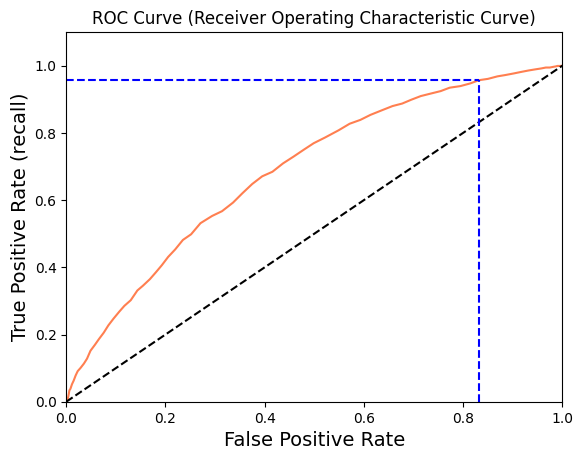

In [37]:
# build the main ROC curve
plt.plot(fpr,
         tpr,
         color='coral',
         label=f"ROC Curve (area = {metrics.auc(fpr, tpr):.3f})",
         )

#add diagnol line 绘制对角线
#good model shold be above this line
#好的模型应该在这条曲线之上
plt.plot([0,1], [0,1], 'k--')

# draw the point on the graph
# be aweare that it's [x1, x2], [y1, y2] instead of [x1,y1]!
plt.plot([0, fpr[idx]], [tpr[idx], tpr[idx]], '--' , color= 'blue' )
plt.plot( [fpr[idx], fpr[idx]], [0, tpr[idx]], '--', color='blue')

# make the graph's basic looks including x-axis and y-axis limits and names and the name of the graph
# basically how your graphy looks like

# first draw the limits
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.1])

# then add the x and y axis labels
plt.xlabel('False Positive Rate', fontsize= 14)
plt.ylabel('True Positive Rate (recall)', fontsize =14 )

# add the graph title
plt.title('ROC Curve (Receiver Operating Characteristic Curve)')

Dashlines to chosen point -- 0.95 (best predict point of the model)

ugghhhhh not a very strong model, now we make final model report

In [38]:
print(metrics.classification_report(y_test, y_pred)) # y_test: real data results od 1 and 0;  y_pred: predicted of 0 and 1

              precision    recall  f1-score   support

           0       0.92      0.57      0.71      8464
           1       0.22      0.70      0.34      1483

    accuracy                           0.59      9947
   macro avg       0.57      0.64      0.52      9947
weighted avg       0.81      0.59      0.65      9947



Now test the Accuracy

In [43]:
# compare testing and training results
y_train_pred = log_model.predict(x_train_scaled)
print(f"Train sample accurancy:  {accuracy_score(y_train, y_train_pred):.3f} ")
print(f"test sample accurancy: {accuracy_score(y_test, y_pred):.3f}" )


Train sample accurancy:  0.639 
test sample accurancy: 0.593


##### build another model -- random forest

In [19]:
from sklearn.ensemble import RandomForestRegressor

In [20]:
# create the model
rf_model = RandomForestClassifier()

In [21]:
rf_model = RandomForestClassifier(
    n_estimators= 200, # how many trees are allowed to build
    max_depth=5 # how tall the trees are allowed to grow
)

# fit the training data in the model
rf_model.fit( X=x_train, y=y_train) # X= inputs ; y= target

RandomForestClassifier(max_depth=5, n_estimators=200)

Boom model trained

In [22]:
# forest model tells you how important each feature is
rf_model.feature_importances_
# it's np arrey

array([2.32245590e-02, 2.23162458e-01, 1.51535613e-02, 1.97581052e-01,
       5.49160561e-02, 9.39325566e-03, 2.49575614e-02, 2.32319326e-03,
       3.68421840e-02, 1.07323515e-02, 1.31572636e-02, 1.20593669e-02,
       7.27391453e-02, 8.23375347e-03, 9.56199241e-03, 1.12725209e-01,
       1.30402304e-01, 0.00000000e+00, 4.52014201e-03, 0.00000000e+00,
       2.35178053e-04, 6.17636879e-04, 4.54741462e-03, 0.00000000e+00,
       8.45953854e-05, 2.13045272e-04, 1.33215469e-04, 1.97331994e-04,
       1.51097146e-03, 5.70339084e-04, 3.18615778e-04, 8.51624577e-04,
       2.77698866e-04, 1.88277214e-03, 5.62626443e-04, 3.47385230e-04,
       0.00000000e+00, 2.15694488e-05, 2.99355985e-04, 9.15048864e-06,
       8.21657767e-04, 2.06402180e-04, 4.84237641e-04, 9.54027846e-04,
       4.10076692e-04, 0.00000000e+00, 5.08731017e-04, 2.11660495e-04,
       2.93667457e-04, 2.82409817e-05, 1.76973584e-04, 3.55932115e-04,
       3.43484017e-04, 1.60582469e-04, 4.80594346e-04, 2.38379869e-04,
      

In [23]:
# make a df of this with x_train
feature_importances_df = pd.DataFrame(zip(
    rf_model.feature_importances_, list(x_train.columns))
)
feature_importances_df.head()

,0,1
0,0.023225,loan_amnt
1,0.223162,int_rate
2,0.015154,installment
3,0.197581,grade
4,0.054916,annual_inc


In [24]:
# re-name columns
feature_importances_df.columns = ('feature importance', 'feature')
feature_importances_df.head()

,feature importance,feature
0,0.023225,loan_amnt
1,0.223162,int_rate
2,0.015154,installment
3,0.197581,grade
4,0.054916,annual_inc


In [25]:
# sort feature importance from more important to less important
feature_importances_df.sort_values( by='feature importance', ascending=False ).head()

,feature importance,feature
1,0.223162,int_rate
3,0.197581,grade
16,0.130402,term_60 months
15,0.112725,term_36 months
12,0.072739,revol_util


check the metracs and build a chart

In [26]:
# build the thing that shows how rf_model works on x_test
rf_model_pred = rf_model.predict_proba(x_test)

In [37]:
print(pd.DataFrame(rf_model_pred))

             0         1
0     0.595208  0.404792
1     0.559139  0.440861
2     0.465348  0.534652
3     0.471239  0.528761
4     0.407462  0.592538
...        ...       ...
9942  0.648891  0.351109
9943  0.618376  0.381624
9944  0.385624  0.614376
9945  0.648102  0.351898
9946  0.586909  0.413091

[9947 rows x 2 columns]


In [27]:
# only the the the part that "possibility of being charged off"
y_predict_proba = rf_model_pred[:,1]
# only get the one that predict who's gonna be charged off in x_test

In [28]:
# get the final yes or no -- when the proba more than 50% it's a 1
y_pred = rf_model.predict(x_test)
# (notes to self: ) it's actually the same as :
# y_pred = ( y_predict_proba >= 0.5 ).astype(int)

In [29]:
# if you want to raise the precentage to 70% iinstead of default 50%
y_pred_70 = (y_predict_proba >= 0.7).astype(int)

now we build the ROC curve!

In [30]:
# import the graph drawing tools
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sn
import numpy as np

In [31]:
# get the fpr, tpr, and thr
[fpr, tpr, thr] = metrics.roc_curve(y_test, y_predict_proba)

In [32]:
# find the first index that the prediction it greater then 0.95
idx = np.min( np.where( tpr > 0.95))
idx

np.int64(2178)

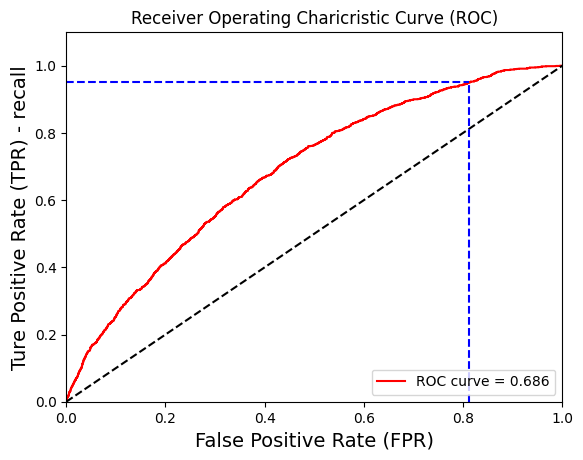

In [33]:
# now draw the graph
# 1, build an empty graph
plt.figure()

#2, deaw the ROC curve
plt.plot( fpr,
         tpr,
          color="red",
          label = f"ROC curve = {metrics.auc(fpr, tpr):.3f}"
         )
# 3, draw the diagnol 对角线
plt.plot( [0, 1], [0, 1], 'k--')

# 4, draw the lines for the index at 0.95 (idx we found)
plt.plot( [0, fpr[idx]], [tpr[idx], tpr[idx]], '--', color='blue')
plt.plot( [fpr[idx], fpr[idx]], [0, tpr[idx]], '--', color='blue')

# 5, set how big the graph is (x and y axis limits)
plt.xlim([0.0 , 1.0])
plt.ylim([0.0, 1.1])

# 6, set the names of each axis
plt.xlabel( "False Positive Rate (FPR)", fontsize=14)
plt.ylabel( "Ture Positive Rate (TPR) - recall", fontsize=14)

# set the graph title
plt.title( "Receiver Operating Charicristic Curve (ROC)")

# legend (corner box)
plt.legend( loc = 'lower right')

plt.show()

In [35]:
# now check metrcs classification report
from sklearn import metrics
print( metrics.classification_report(y_test, y_pred)) # compare original data from y_test to model predict y_pred


              precision    recall  f1-score   support

           0       0.91      0.63      0.74      8464
           1       0.23      0.64      0.34      1483

    accuracy                           0.63      9947
   macro avg       0.57      0.63      0.54      9947
weighted avg       0.81      0.63      0.68      9947



In [38]:
# accurancy
# get the model predict results from x_train
y_train_pred = rf_model.predict(x_train)
# get the accuracny score
print( f"train sample accuracy: {accuracy_score(y_train, y_train_pred):.4f}")
print(f"test sample accuracy: {accuracy_score(y_test, y_pred):.4f}")

train sample accuracy: 0.6448
test sample accuracy: 0.6272


due to limited database about credit users' info, neither of the models are perfect. However, by comparision, rf_model by random forest is better than logistic regression, so we save this model for users to load.

In [39]:
import joblib
joblib.dump(rf_model, 'credit_risk_ML_model.pkl')

['credit_risk_ML_model.pkl']